In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import pandas as pd
import xarray as xr
from population_utils import *

In [3]:
from utils.format_data import flatten_series

In [4]:
full_df = pd.read_pickle('/home/niell_lab/data/freely_moving_ephys/batch_files/092421/pooled_ephys_population_update_092421.pickle')

In [22]:
def get_peak_trough(wv, baseline):
    wv = [i-baseline for i in wv]
    wv_flip = [-i for i in wv]
    peaks, peak_props = find_peaks(wv, height=1.2)
    troughs, trough_props = find_peaks(wv_flip, height=1.2)
    if len(peaks) > 1:
        peaks = peaks[np.argmax(peak_props['peak_heights'])]
    if len(troughs) > 1:
        troughs = troughs[np.argmax(trough_props['peak_heights'])]
    if peaks.size == 0:
        peaks = np.nan
    if troughs.size == 0:
        troughs = np.nan
    if ~np.isnan(peaks):
        peaks = int(peaks)
    if ~np.isnan(troughs):
        troughs = int(troughs)
    return peaks, troughs

In [23]:
def get_cluster_props(p, t):
    possible_labels = ['biphasic','negative','early_positive','late_positive','unresponsive']
    if ~np.isnan(p):
        has_peak = True
        peak_cent = p
    else:
        has_peak = False
        peak_cent = None
    if ~np.isnan(t):
        has_trough = True
        trough_cent = t
    else:
        has_trough = False
        trough_cent = None
    if has_peak and has_trough:
        return 'biphasic'
    elif has_trough and ~has_peak:
        return 'negative'
    elif peak_cent is not None and peak_cent <= (42-38):
        return 'early'
    elif peak_cent is not None and peak_cent > (42-38):
        return 'late'
    else:
        return 'unresponsive'

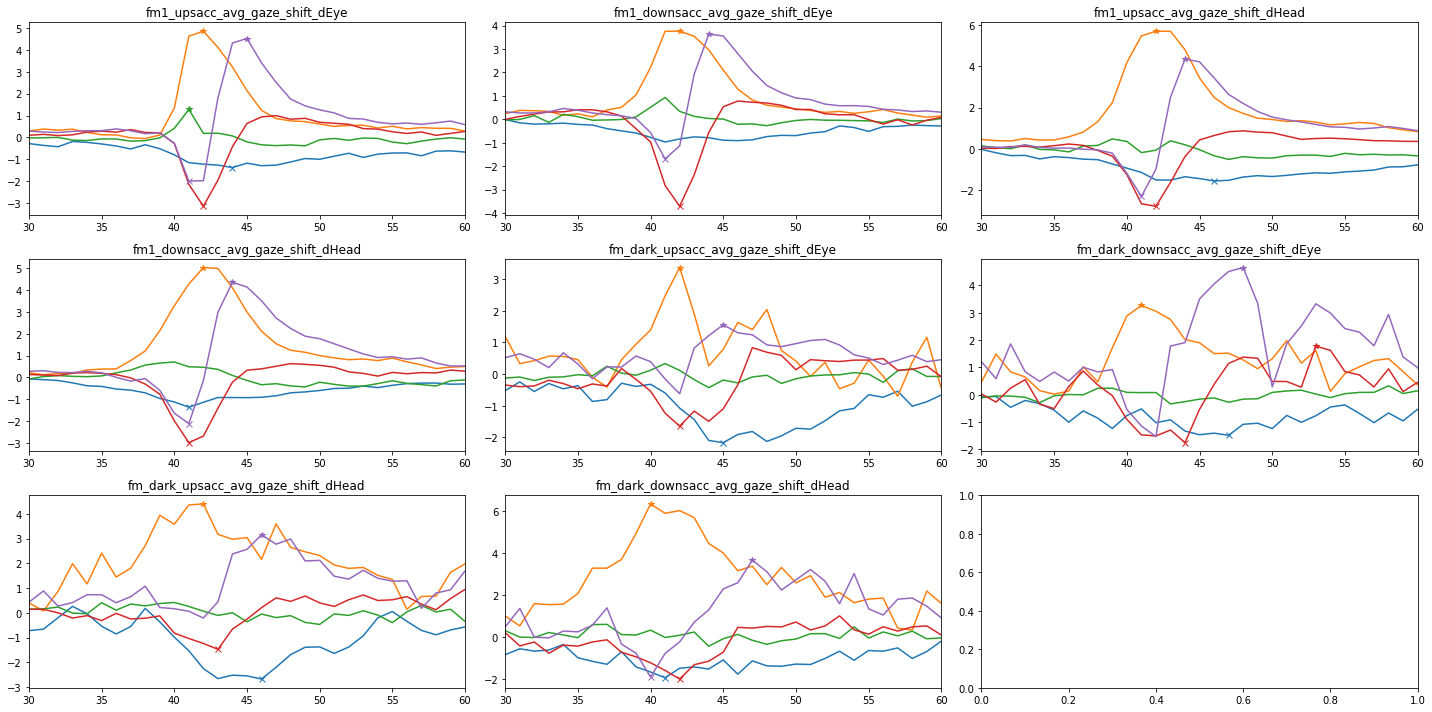

In [28]:
waveforms = ['fm1_upsacc_avg_gaze_shift_dEye', 'fm1_downsacc_avg_gaze_shift_dEye', 'fm1_upsacc_avg_gaze_shift_dHead', 'fm1_downsacc_avg_gaze_shift_dHead', 'fm_dark_upsacc_avg_gaze_shift_dEye', 'fm_dark_downsacc_avg_gaze_shift_dEye', 'fm_dark_upsacc_avg_gaze_shift_dHead', 'fm_dark_downsacc_avg_gaze_shift_dHead']
plt.subplots(3,int(np.ceil(len(waveforms)/3)), figsize=(20,10))
for x in range(len(waveforms)):
    plt.subplot(3,int(np.ceil(len(waveforms)/3)),x+1)
    waveform_label = [i+'_cluster' for i in waveforms][x]
    for label in range(5):
        mean_psth = np.nanmean(flatten_series(full_df[waveforms[x]][full_df[waveforms[x]+'_cluster']==label].dropna()),0)
        baseline = np.nanmean(mean_psth[:25])
        p, t = get_peak_trough(mean_psth, baseline)
        tempcolor = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple'][label]
        plt.plot(mean_psth-baseline, color=tempcolor)
        if ~np.isnan(t):
            plt.plot(t, (mean_psth-baseline)[t], 'x', color=tempcolor)
        if ~np.isnan(p):
            plt.plot(p, (mean_psth-baseline)[p], '*', color=tempcolor)
    plt.xlim([30,60])
    plt.title(waveforms[x])
plt.tight_layout()

In [47]:
count = 0
for i in range(len(full_df)):
    for j in range(len(waveforms)):
        count += 1
count

3235968

In [165]:
from sklearn.cluster import KMeans, SpectralClustering

In [169]:
waveform_keys = ['fm1_upsacc_avg_gaze_shift_dEye', 'fm1_downsacc_avg_gaze_shift_dEye', 'fm1_upsacc_avg_gaze_shift_dHead', 'fm1_downsacc_avg_gaze_shift_dHead', 'fm_dark_upsacc_avg_gaze_shift_dEye', 'fm_dark_downsacc_avg_gaze_shift_dEye', 'fm_dark_upsacc_avg_gaze_shift_dHead', 'fm_dark_downsacc_avg_gaze_shift_dHead']
wv_inds = list(np.floor(np.arange(0, len(full_df[waveform_keys].values), 1/len(waveform_keys))).astype(int))
flat_waveforms = np.zeros([len(full_df)*len(waveform_keys), 20])
count = 0
for ind, row in full_df.iterrows():
    waveforms = full_df[waveform_keys].values.flatten()
    for wv_ind in range(len(waveform_keys)):
        wv = waveforms[wv_ind]
        if type(wv) != float:
            baseline = np.nanmean(wv[:25])
            deflection = [i-baseline for i in wv]
            psth_zscore = (np.max(np.abs(deflection))-np.mean(deflection)) / np.std(baseline)
            if np.abs(psth_zscore) > 2:
                flat_waveforms[count,:] = deflection[35:55] / np.max(np.abs(deflection[35:55]))
        count += 1
km_labels = KMeans(n_clusters=5).fit(flat_waveforms[~np.isnan(flat_waveforms).any(axis=1)]).labels_
bad_waveforms = np.argwhere(np.isnan(flat_waveforms).any(axis=1)).T.tolist()[0]
for bad in bad_waveforms:
    km_labels = np.insert(km_labels, bad, -1)
for ind, row in full_df.iterrows():
    unit_clusters = km_labels[[i for i, x in enumerate(wv_inds) if x == ind]]
    for keynum in range(len(unit_clusters)):
        full_df.at[ind, waveform_keys[keynum]+'_cluster_new'] = unit_clusters[keynum]

In [170]:
np.shape(flat_waveforms[~np.isnan(flat_waveforms).any(axis=1)])

(5088, 20)

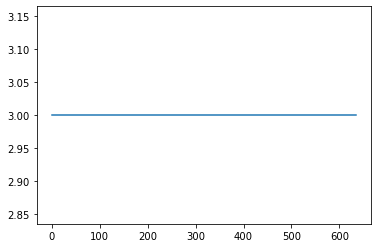

In [137]:
plt.plot(full_df[waveform_keys[0]+'_cluster_new'])

IndexError: single positional indexer is out-of-bounds

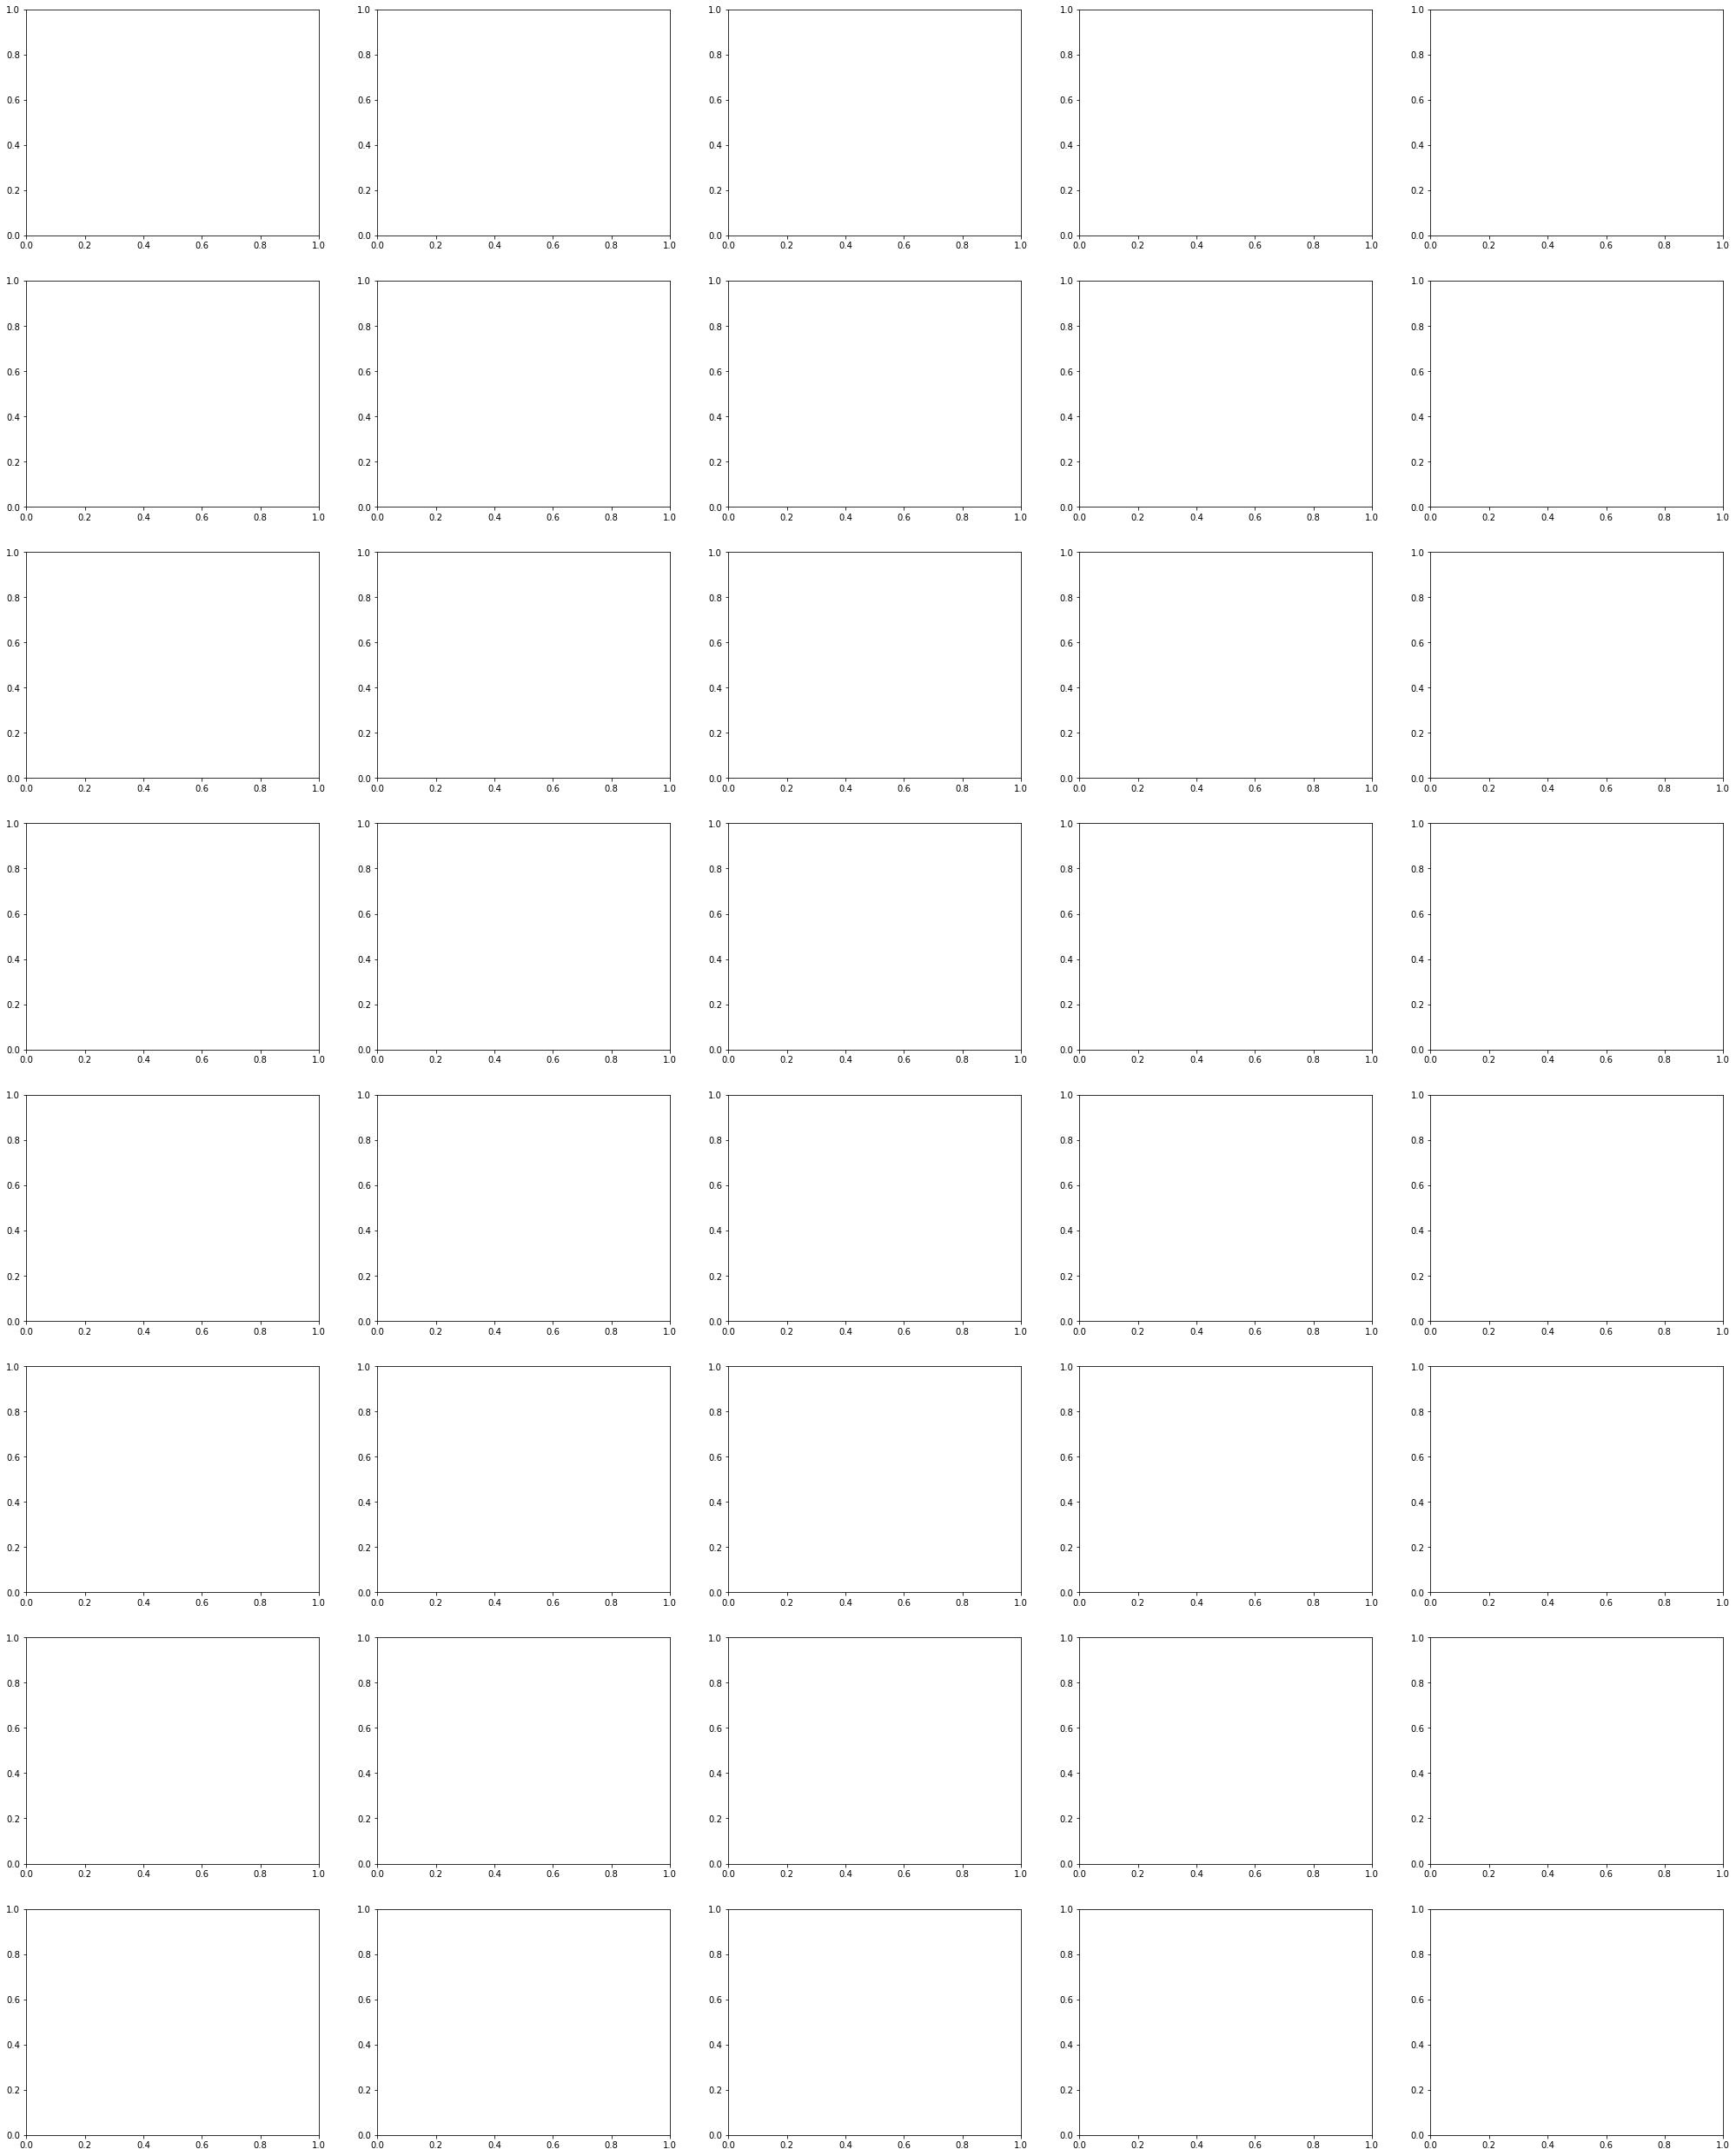

In [61]:
trange = np.arange(-1,1.1,0.025)
plt.subplots(8,5, figsize=(35,45))
subplotcount = 1
mean_cluster_all_keys = {}
colors = plt.cm.jet(np.arange(-650,650))
for key in waveform_keys:
    for label in range(5):
        plt.subplot(8,5,subplotcount)
        plt.plot(0.5*(trange[0:-1] + trange[1:]), flatten_series(full_df[key][full_df[key+'_cluster'].astype(int)==label]))
        plt.xlim([-0.5,0.75])
        subplotcount += 1

In [75]:
full_df[key][full_df[key+'_cluster'].astype(int)==label]

Series([], Name: fm1_upsacc_avg_gaze_shift_dEye, dtype: object)

In [76]:
full_df[key+'_cluster']

0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
      ... 
631    2.0
632    2.0
633    2.0
634    2.0
635    2.0
Name: fm1_upsacc_avg_gaze_shift_dEye_cluster, Length: 636, dtype: float64

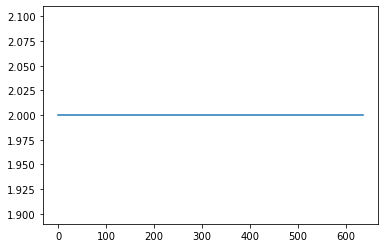

In [73]:
plt.plot(full_df[key+'_cluster'].astype(int))

In [44]:
np.shape(flat_waveforms)

(5088, 20)

In [29]:
ind

79

In [31]:
km_labels[[i for i, x in enumerate(wv_inds) if x == 78]]

array([1, 1, 3, 4, 3, 1, 4, 1], dtype=int32)

In [15]:
len(km_labels)

636

In [9]:
full_df[full_df[waveforms[x]+'_cluster']==label]

,level_0,index,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,...,fm_dark_upsacc_avg_comp_dHead_cluster,fm_dark_downsacc_avg_comp_dHead_cluster,fm1_upsacc_avg_comp_dEye_cluster_type,fm1_downsacc_avg_comp_dEye_cluster_type,fm1_upsacc_avg_comp_dHead_cluster_type,fm1_downsacc_avg_comp_dHead_cluster_type,fm_dark_upsacc_avg_comp_dEye_cluster_type,fm_dark_downsacc_avg_comp_dEye_cluster_type,fm_dark_upsacc_avg_comp_dHead_cluster_type,fm_dark_downsacc_avg_comp_dHead_cluster_type
3,3,11,1314.7,9.9,good,65.532364,13,451,23.512966,good,...,2.0,2.0,early,unresponsive,unresponsive,early,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
4,4,12,916.5,12.8,mua,71.809006,15,401,5.896834,good,...,2.0,2.0,early,unresponsive,unresponsive,early,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
5,5,13,1444.9,8.7,good,77.080399,15,401,5.248946,good,...,2.0,2.0,early,unresponsive,unresponsive,unresponsive,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
12,12,32,1033.8,0.0,good,91.833069,35,701,1.320564,good,...,2.0,2.0,unresponsive,unresponsive,unresponsive,unresponsive,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
18,18,40,2241.5,1.4,good,95.084503,28,75,7.391204,good,...,2.0,2.0,unresponsive,unresponsive,unresponsive,unresponsive,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,561,65,1728.5,0.7,good,132.754608,52,275,18.095479,good,...,2.0,3.0,early,unresponsive,unresponsive,early,unresponsive,unresponsive,unresponsive,unresponsive
586,586,8,5365.3,0.0,good,93.603027,6,625,0.831394,good,...,2.0,2.0,unresponsive,unresponsive,unresponsive,unresponsive,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
589,589,11,2465.6,0.0,good,111.460419,7,600,0.274190,good,...,2.0,2.0,unresponsive,unresponsive,early,unresponsive,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
604,604,104,3397.5,0.0,good,115.554764,47,400,0.403161,good,...,2.0,2.0,unresponsive,unresponsive,unresponsive,early,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>


In [51]:
np.shape(full_df[full_df[waveforms[x]+'_cluster']==label])

(72, 530)

In [54]:
full_df[waveforms[x]]#==label]

KeyError: False

In [ ]:
np.size(full_df)

In [14]:
biphasic

,level_0,index,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,...,fm_dark_upsacc_avg_comp_dHead_cluster,fm_dark_downsacc_avg_comp_dHead_cluster,fm1_upsacc_avg_comp_dEye_cluster_type,fm1_downsacc_avg_comp_dEye_cluster_type,fm1_upsacc_avg_comp_dHead_cluster_type,fm1_downsacc_avg_comp_dHead_cluster_type,fm_dark_upsacc_avg_comp_dEye_cluster_type,fm_dark_downsacc_avg_comp_dEye_cluster_type,fm_dark_upsacc_avg_comp_dHead_cluster_type,fm_dark_downsacc_avg_comp_dHead_cluster_type
6,6,14,975.5,11.2,mua,61.669289,17,351,22.158574,good,...,1.0,1.0,late,unresponsive,early,late,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
10,10,30,2166.8,5.2,good,91.671196,33,751,5.566564,good,...,1.0,1.0,early,unresponsive,unresponsive,early,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
11,11,31,1274.5,7.4,good,72.024826,35,701,2.394524,good,...,1.0,1.0,unresponsive,early,early,unresponsive,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
15,15,38,1728.5,4.9,good,102.879143,39,601,4.906281,good,...,1.0,1.0,negative,biphasic,biphasic,unresponsive,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
16,16,27,1213.9,4.0,good,63.551121,16,375,17.498197,good,...,1.0,1.0,late,unresponsive,unresponsive,late,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,601,50,1708.0,1.3,good,71.278313,21,250,5.200778,good,...,1.0,1.0,unresponsive,unresponsive,unresponsive,unresponsive,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>,<ufunc 'isnan'>
618,618,43,1096.1,3.6,good,77.885635,21,250,10.336045,good,...,1.0,1.0,late,unresponsive,unresponsive,unresponsive,unresponsive,unresponsive,unresponsive,unresponsive
619,619,45,888.8,4.7,good,56.591965,22,225,7.414140,good,...,1.0,1.0,unresponsive,unresponsive,unresponsive,unresponsive,unresponsive,unresponsive,unresponsive,unresponsive
622,622,55,1464.3,4.9,good,70.190681,25,150,19.425222,good,...,1.0,1.0,late,unresponsive,unresponsive,late,unresponsive,unresponsive,unresponsive,unresponsive


In [18]:
this_cluster = get_cluster_props(p, t)
plt.plot(mean_psth)

(72, 83)

In [4]:
dmodels = np.load('/home/niell_lab/data/freely_moving_ephys/batch_files/092121/dmodels.npy')

In [5]:
df = full_df[full_df['session']=='070921_J553RT_control_Rig2']

In [6]:
count = 0
for ind, row in df.iterrows():
    df.at[ind, 'theta_multiplicative_addative_index'] = dmodels[count,0,:].astype(object)
    df.at[ind, 'phi_multiplicative_addative_index'] = dmodels[count,1,:].astype(object)
    df.at[ind, 'roll_multiplicative_addative_index'] = dmodels[count,2,:].astype(object)
    df.at[ind, 'pitch_multiplicative_addative_index'] = dmodels[count,3,:].astype(object)
    count += 1

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  3.,
         2.,  3.,  4.,  2.,  5.,  7., 11.,  7.,  7., 16.,  3.,  9.,  8.,
         6.,  7.,  4.,  4.,  4.,  2.,  1.,  3.,  1.,  1.,  2.]),
 array([-6.3300e-01, -6.1716e-01, -6.0132e-01, -5.8548e-01, -5.6964e-01,
        -5.5380e-01, -5.3796e-01, -5.2212e-01, -5.0628e-01, -4.9044e-01,
        -4.7460e-01, -4.5876e-01, -4.4292e-01, -4.2708e-01, -4.1124e-01,
        -3.9540e-01, -3.7956e-01, -3.6372e-01, -3.4788e-01, -3.3204e-01,
        -3.1620e-01, -3.0036e-01, -2.8452e-01, -2.6868e-01, -2.5284e-01,
        -2.3700e-01, -2.2116e-01, -2.0532e-01, -1.8948e-01, -1.7364e-01,
        -1.5780e-01, -1.4196e-01, -1.2612e-01, -1.1028e-01, -9.4440e-02,
        -7.8600e-02, -6.2760e-02, -4.6920e-02, -3.1080e-02, -1.5240e-02,
         6.0000e-04,  1.6440e-02,  3.2280e-02,  4.8120e-02,  6.3960e-02,
         7.9800e-02,  9.5640e-02,  1.1148e-01,  1.2732e-01,

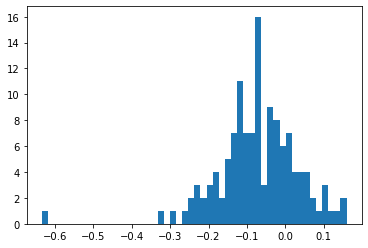

In [33]:
plt.hist(df['fm1_spike_rate_vs_theta_modind_pos'], bins=50)

In [38]:
thresh = 0.02
th_resp = df[(np.abs(df['fm1_spike_rate_vs_theta_modind_neg'])>thresh) * (np.abs(df['fm1_spike_rate_vs_theta_modind_pos'])>thresh)]
phi_resp = df[(np.abs(df['fm1_spike_rate_vs_phi_modind_neg'])>thresh) * (np.abs(df['fm1_spike_rate_vs_phi_modind_pos'])>thresh)]
roll_resp = df[(np.abs(df['fm1_spike_rate_vs_roll_modind_neg'])>thresh) * (np.abs(df['fm1_spike_rate_vs_roll_modind_pos'])>thresh)]
pitch_resp = df[(np.abs(df['fm1_spike_rate_vs_pitch_modind_neg'])>thresh) * (np.abs(df['fm1_spike_rate_vs_pitch_modind_pos'])>thresh)]

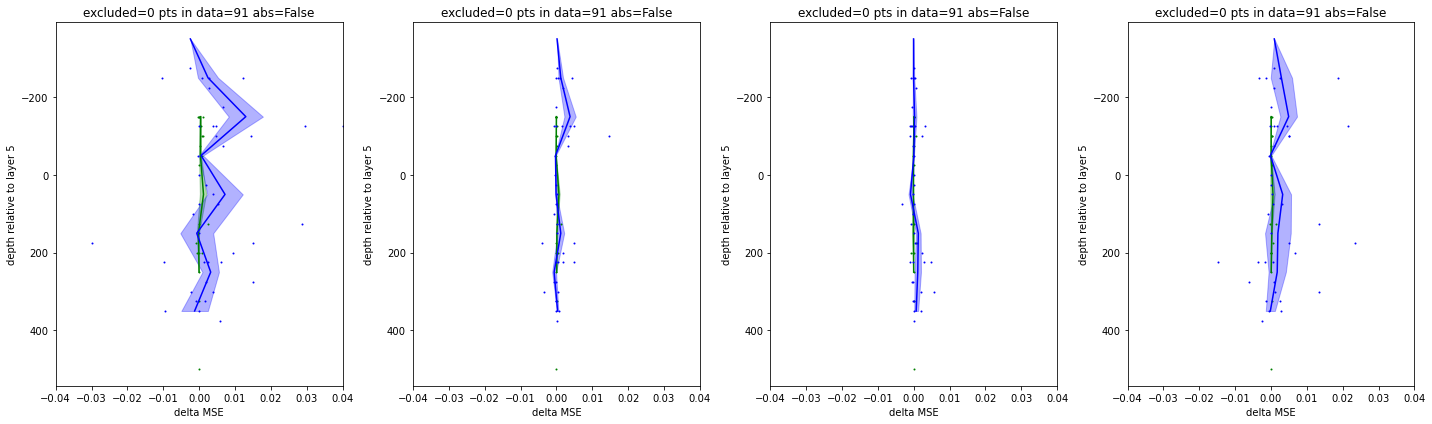

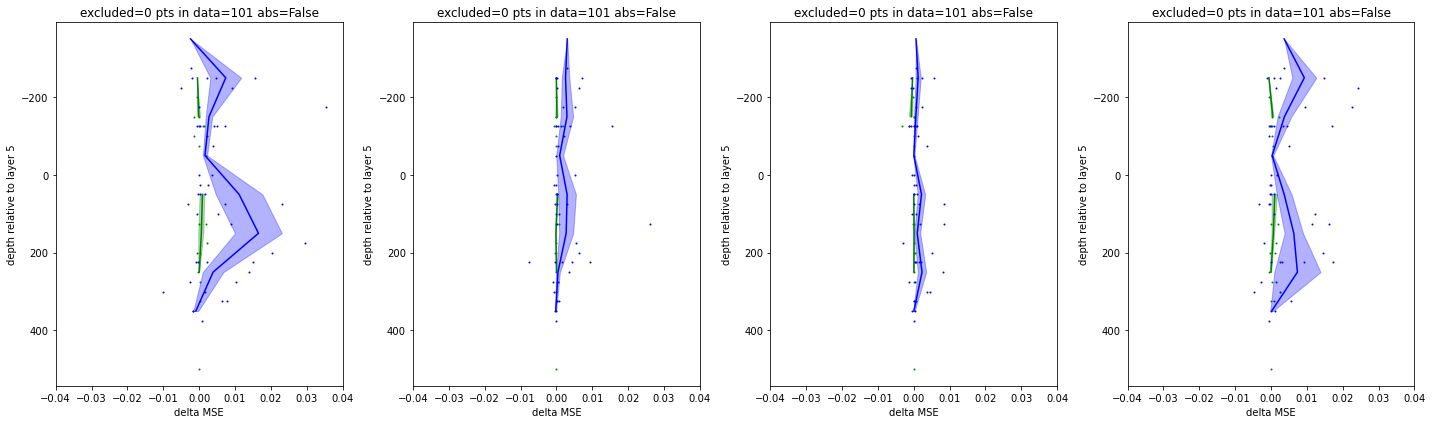

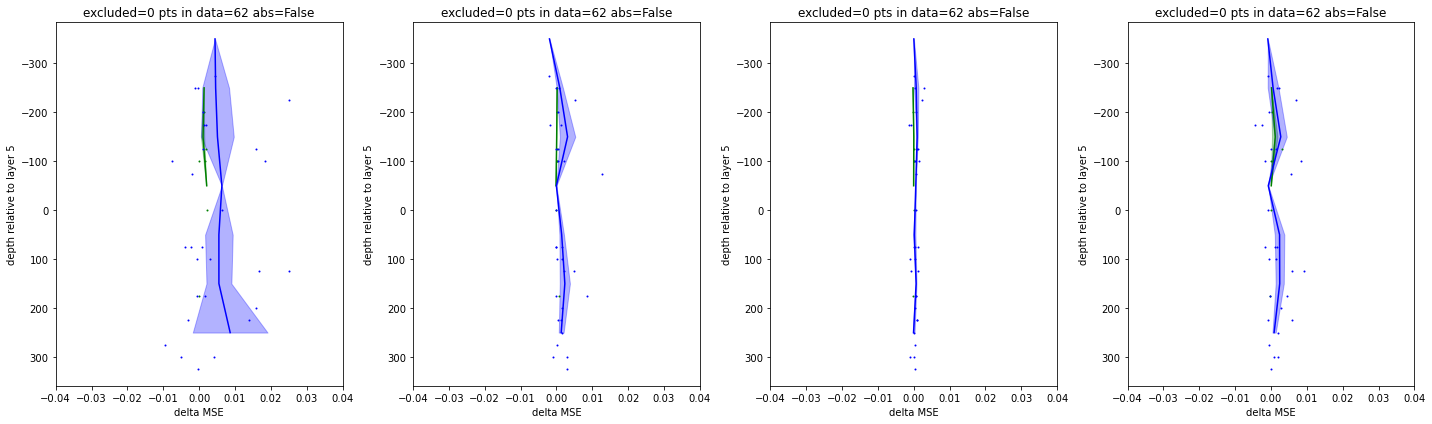

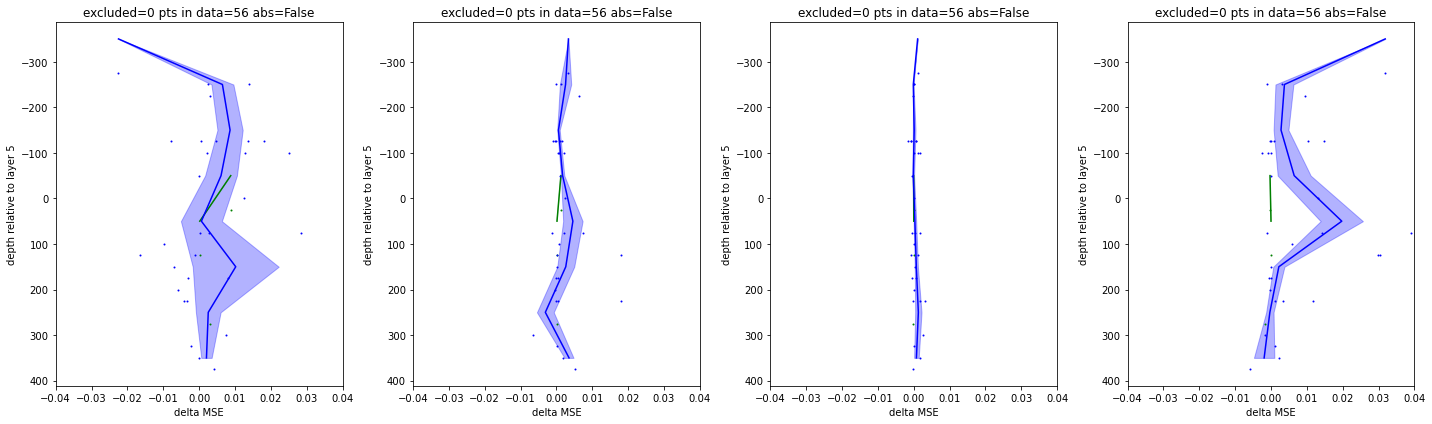

In [39]:
for prop_num in range(4):
    prop = ['theta','phi','roll','pitch'][prop_num]
    data = [th_resp, phi_resp, roll_resp, pitch_resp][prop_num]
    plt.subplots(1,4,figsize=(20,6))
    for c in range(4):
        fig = plot_var_vs_var(data, prop+'_multiplicative_addative_index', 'hf1_wn_depth_from_layer5', (1,4,c+1), filter_for={'fires_2sp_sec':True}, force_range=np.arange(-650,750,100), along_y=True, abs=False, xpos_to_index=c)
        plt.xlabel('delta MSE'); plt.ylabel('depth relative to layer 5')
        plt.gca().invert_yaxis()
        plt.xlim([-0.04,0.04])
    plt.tight_layout()